#Face detection and blurring with Python and OpenCV

In [28]:
!pip install mediapipe
!ls -F /content/

import os
import time
import cv2
import mediapipe as mp
# Import the MediaPipe Tasks API
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python import vision

# --- DEBUGGING PRINTS ---
print(f"Mediapipe module loaded from: {mp.__file__}")
if hasattr(mp, '__path__'):
    print(f"Mediapipe module path: {mp.__path__}")
    # Further inspection: list contents of the mediapipe package directory
    print("Listing contents of mediapipe package directory:")
    for path in mp.__path__:
        !ls -F "{path}"
else:
    print("Mediapipe module has no __path__ attribute (it's likely a single file module).")
# ------------------------

def process_img(img, face_detector_instance):
    if img is None:
        return None

    H, W = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to MediaPipe's Image format
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)

    # Perform face detection
    detection_result = face_detector_instance.detect(mp_image)

    if detection_result and detection_result.detections:
        for detection in detection_result.detections:
            # Bounding box is now an absolute pixel value
            bbox_raw = detection.bounding_box

            x1 = bbox_raw.origin_x
            y1 = bbox_raw.origin_y
            w  = bbox_raw.width
            h  = bbox_raw.height

            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(W, x1 + w)
            y2 = min(H, y1 + h)

            if x2 <= x1 or y2 <= y1:
                continue

            roi = img[y1:y2, x1:x2]

            # Blur kernel proportional to face size (must be odd)
            k = max(15, (min(x2 - x1, y2 - y1) // 3) | 1)
            img[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (k, k), 0)

    return img


# ------------------------
# CONFIG
# ------------------------
MODE = "webcam"   # "image", "video", or "webcam"
FILE_PATH = None  # set path when MODE is "image" or "video"

output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

# Path to the face detection model
model_path = 'face_detector.tflite'

# Download the model if it doesn't exist
if not os.path.exists(model_path):
    print(f"Downloading face detection model to {model_path}...")
    # This URL points to a standard MediaPipe face detector model
    !wget -q -O {model_path} https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite
    print("Download complete.")

# Configure FaceDetectorOptions for the MediaPipe Tasks API
base_options = BaseOptions(model_asset_path=model_path)
options = vision.FaceDetectorOptions(base_options=base_options, min_detection_confidence=0.5)

# Initialize the Face Detector using the new API
with vision.FaceDetector.create_from_options(options) as face_detector:

    if MODE == "image":
        if not "/Users/xiangfan/Downloads/testImg.png":
            raise ValueError("Set FILE_PATH to your image path when MODE='image'.")

        img = cv2.imread("/Users/xiangfan/Downloads/testImg.png")
        if img is None:
            raise FileNotFoundError(f"Could not read image: {"/Users/xiangfan/Downloads/testImg.png"}")

        img_out = process_img(img, face_detector)
        out_path = os.path.join(output_dir, "output.jpg")
        cv2.imwrite(out_path, img_out)
        print("Saved:", out_path)

    elif MODE == "video":
        if not "/Users/xiangfan/Downloads/testVideo.mp4":
            raise ValueError("Set FILE_PATH to your video path when MODE='video'.")

        cap = cv2.VideoCapture(FILE_PATH)
        if not cap.isOpened():
            raise RuntimeError(f"Could not open video: {"/Users/xiangfan/Downloads/testVideo.mp4"}")

        fps = cap.get(cv2.CAP_PROP_FPS)
        if not fps or fps <= 0:
            fps = 25

        ret, frame = cap.read()
        if not ret or frame is None:
            raise RuntimeError("Could not read first frame of video")

        out_path = os.path.join(output_dir, "output.mp4")
        writer = cv2.VideoWriter(
            out_path,
            cv2.VideoWriter_fourcc(*"mp4v"),
            fps,
            (frame.shape[1], frame.shape[0])
        )

        while ret and frame is not None:
            frame_out = process_img(frame, face_detector)
            writer.write(frame_out)
            ret, frame = cap.read()

        cap.release()
        writer.release()
        print("Saved:", out_path)

    elif MODE == "webcam":
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            raise RuntimeError("Webcam not accessible")

        print("Controls: ESC quit | S save JPG snapshot")

        while True:
            ret, frame = cap.read()
            if not ret or frame is None:
                break

            frame_out = process_img(frame, face_detector)
            cv2.imshow("Face Blur", frame_out)

            key = cv2.waitKey(1) & 0xFF
            if key == 27:  # ESC
                break
            if key in (ord("s"), ord("S")):
                ts = time.strftime("%Y%m%d_%H%M%S")
                snap_path = os.path.join(output_dir, f"snapshot_{ts}.jpg")
                cv2.imwrite(snap_path, frame_out)
                print("Saved:", snap_path)

        cap.release()
        cv2.destroyAllWindows()

    else:
        raise ValueError("MODE must be 'image', 'video', or 'webcam'.")

face_detector.tflite  output/  sample_data/
Mediapipe module loaded from: /usr/local/lib/python3.12/dist-packages/mediapipe/__init__.py
Mediapipe module path: ['/usr/local/lib/python3.12/dist-packages/mediapipe']
Listing contents of mediapipe package directory:
__init__.py  modules/  __pycache__/  tasks/


RuntimeError: Webcam not accessible

In [20]:
!pip -q install mediapipe opencv-python

import os, time, cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow

output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

model_path = "face_detector.tflite"
if not os.path.exists(model_path):
    !wget -q -O {model_path} https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

base_options = BaseOptions(model_asset_path=model_path)
options = vision.FaceDetectorOptions(
    base_options=base_options,
    min_detection_confidence=0.5
)


In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=cv2.IMREAD_COLOR)
    return img


<IPython.core.display.Javascript object>

Saved: ./output/snapshot_20260204_195836.jpg


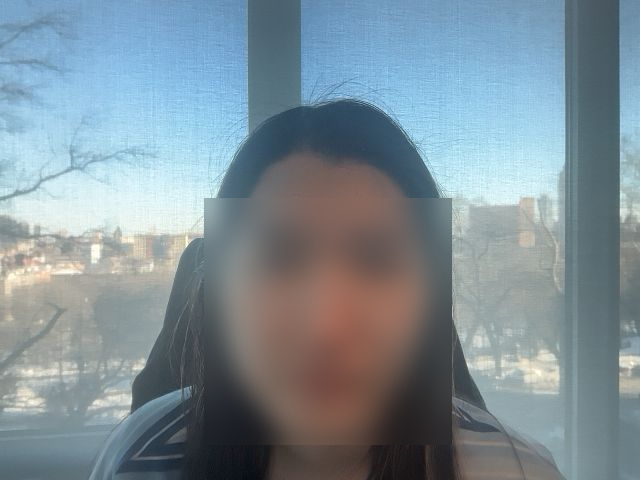

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [27]:
def process_img(img_bgr, face_detector):
    H, W = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)

    detection_result = face_detector.detect(mp_image)

    if detection_result and detection_result.detections:
        for det in detection_result.detections:
            bbox = det.bounding_box  # absolute pixels
            x1, y1, w, h = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x1 + w), min(H, y1 + h)
            if x2 <= x1 or y2 <= y1:
                continue

            roi = img_bgr[y1:y2, x1:x2]
            k = max(15, (min(x2 - x1, y2 - y1) // 3) | 1)  # odd
            img_bgr[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (k, k), 0)

    return img_bgr

with vision.FaceDetector.create_from_options(options) as face_detector:
    for i in range(3):  # capture 3 frames (change as needed)
        frame = take_photo()
        out = process_img(frame, face_detector)

        out_path = os.path.join(output_dir, f"snapshot_{time.strftime('%Y%m%d_%H%M%S')}.jpg")
        cv2.imwrite(out_path, out)
        print("Saved:", out_path)

        cv2_imshow(out)


In [29]:
#(Run locally on your Mac): make OpenCV webcam work
#If you are on macOS, VideoCapture(0) failing is usually permission or backend.
#Minimal robust webcam open for macOS


cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)  # macOS backend
if not cap.isOpened():
    raise RuntimeError("Webcam not accessible. Check macOS camera permission for your Python/IDE.")


RuntimeError: Webcam not accessible. Check macOS camera permission for your Python/IDE.